# Example 4: Classification

## Regression formulation

Let's first treat the problem as a regression problem (output dimension = 1, MSE loss).

create the two moon dataset

In [4]:
! pip install pykan
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jonathanoheix/face-expression-recognition-dataset
! unzip face-expression-recognition-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
face-expression-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  face-expression-recognition-dataset.zip
replace images/images/train/angry/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace images/images/train/angry/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


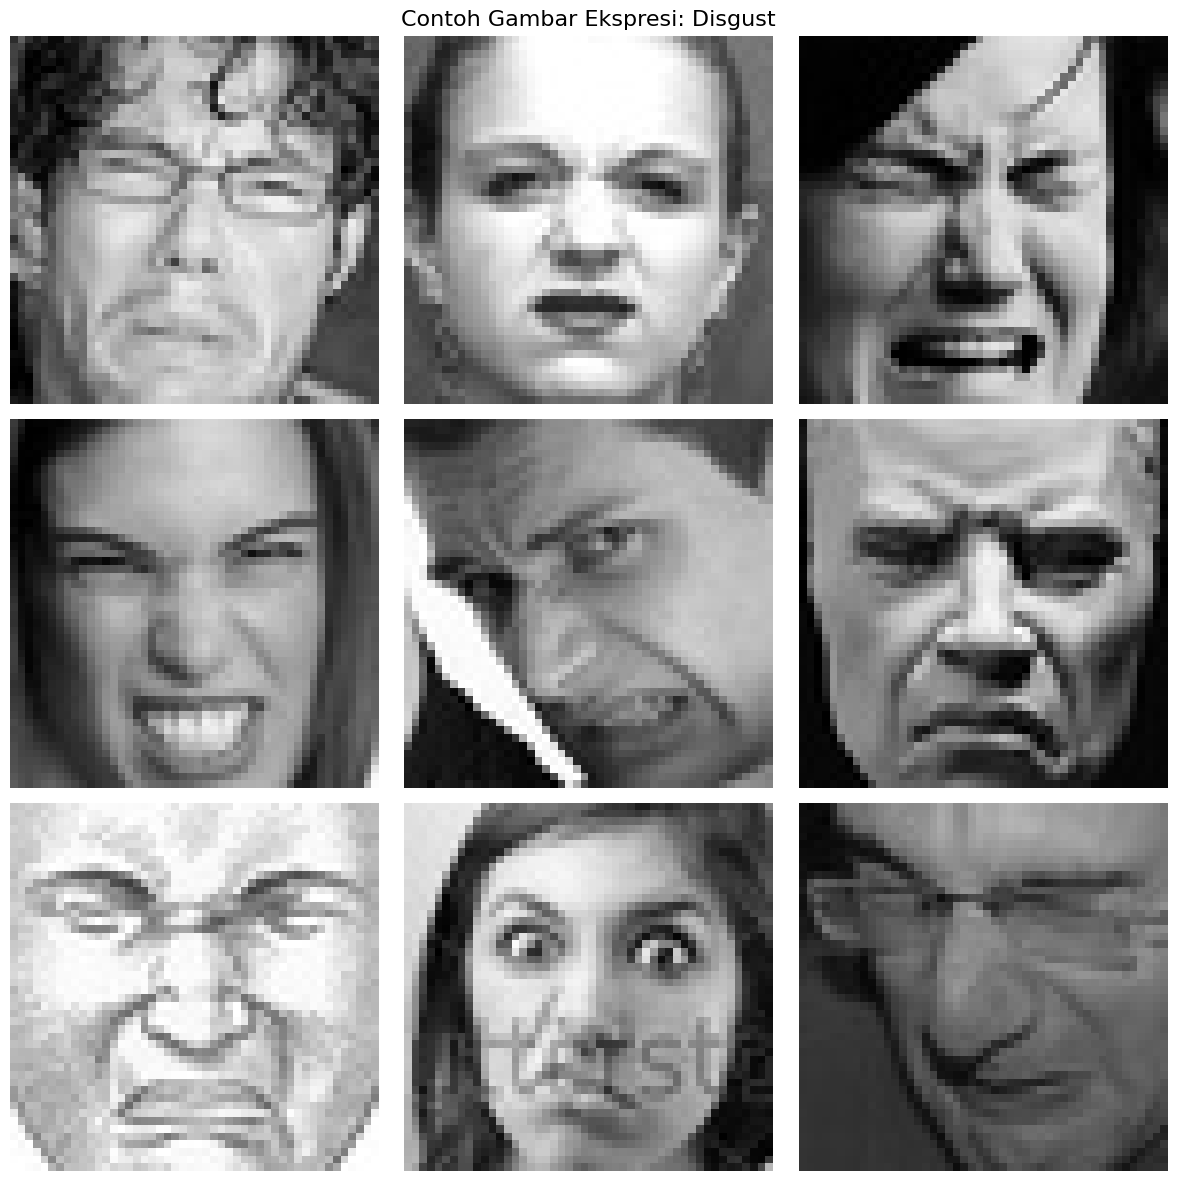

In [5]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img

# Pengaturan untuk visualisasi gambar
picture_size = 48
folder_path = "/content/images/images/"
train_path = os.path.join(folder_path, "train")
val_path = os.path.join(folder_path, "validation")
expression = 'disgust'

# Visualisasi gambar ekspresi wajah
plt.figure(figsize=(12, 12))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    img_path = os.path.join(folder_path, "train", expression, os.listdir(os.path.join(folder_path, "train", expression))[i])
    img = load_img(img_path, target_size=(picture_size, picture_size))
    plt.imshow(img)
    plt.axis('off')
plt.suptitle(f"Contoh Gambar Ekspresi: {expression.capitalize()}", fontsize=16)
plt.tight_layout()
plt.show()

Train KAN

In [ ]:


model = KAN(width=[2,1], grid=3, k=3, device=device)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 1.56e-01 | reg: 3.94e+00 | : 100%|█| 20/20 [00:01<00:00, 15.55it

saving model version 0.1


(1.0, 0.9980000257492065)

Automatic symbolic regression

In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with sin, r2=0.9654733538627625, c=2
fixing (0,1,0) with x, r2=0.975755512714386, c=1
saving model version 0.2


-0.853*x_2 - 0.3885*sin(3.1242*x_1 - 1.5464) + 0.7063

How accurate is this formula?

In [ ]:
# how accurate is this formula?
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)) == y[i,0]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.9980, device='cuda:0')
test acc of the formula: tensor(0.9970, device='cuda:0')


## Classification formulation

Let's then treat the problem as a classification problem (output dimension = 2, CrossEntropy loss).

Inisiasi Kaggle dan load dataset

In [2]:
! pip install pykan
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jonathanoheix/face-expression-recognition-dataset
! unzip face-expression-recognition-dataset

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  in

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from kan import *
import torch

# Pengaturan
picture_size = 48
folder_path = "/content/images/images/"
train_path = os.path.join(folder_path, "train")
val_path = os.path.join(folder_path, "validation")
expression = 'disgust'

# Fungsi untuk memuat gambar
def load_images(path):
    images = []
    labels = []
    for label, emotion in enumerate(os.listdir(path)):
        emotion_path = os.path.join(path, emotion)
        for img_name in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_name)
            img = Image.open(img_path).convert('L')  # Konversi ke grayscale
            img = np.array(img).reshape(picture_size * picture_size)  # Flatten image
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Memuat dataset
train_input, train_label = load_images(train_path)
test_input, test_label = load_images(val_path)

# Visualisasi gambar ekspresi wajah
plt.figure(figsize=(12, 12))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    img_path = os.path.join(train_path, expression, os.listdir(os.path.join(train_path, expression))[i])
    img = Image.open(img_path).convert('L')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle(f"Contoh Gambar Ekspresi: {expression.capitalize()}", fontsize=16)
plt.tight_layout()
plt.show()

# Konversi ke PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = {
    'train_input': torch.from_numpy(train_input).float().to(device),
    'test_input': torch.from_numpy(test_input).float().to(device),
    'train_label': torch.from_numpy(train_label).long().to(device),
    'test_label': torch.from_numpy(test_label).long().to(device)
}

# Normalisasi input (opsional, tapi sering membantu)
dataset['train_input'] /= 255.0
dataset['test_input'] /= 255.0

# Print informasi dataset
print(f"Train input shape: {dataset['train_input'].shape}")
print(f"Train label shape: {dataset['train_label'].shape}")
print(f"Test input shape: {dataset['test_input'].shape}")
print(f"Test label shape: {dataset['test_label'].shape}")

# Visualisasi distribusi label
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(dataset['train_label'].cpu().numpy(), bins=len(np.unique(train_label)))
plt.title('Distribution of Training Labels')
plt.subplot(1, 2, 2)
plt.hist(dataset['test_label'].cpu().numpy(), bins=len(np.unique(test_label)))
plt.title('Distribution of Testing Labels')
plt.tight_layout()
plt.show()

NameError: name '_C' is not defined

### Train KAN

In [8]:
import torch
from kan import KAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Inisialisasi model KAN
input_size = dataset['train_input'].shape[1]  # Jumlah fitur (48*48 = 2304 untuk gambar 48x48)
num_classes = len(torch.unique(dataset['train_label']))
model = KAN(width=[input_size, 64, 32, num_classes], grid=3, k=3, seed=2024, device=device)

# Fungsi untuk menghitung akurasi training
def train_acc():
    with torch.no_grad():
        predictions = model(dataset['train_input'])
        return torch.mean((torch.argmax(predictions, dim=1) == dataset['train_label']).float())

# Fungsi untuk menghitung akurasi testing
def test_acc():
    with torch.no_grad():
        predictions = model(dataset['test_input'])
        return torch.mean((torch.argmax(predictions, dim=1) == dataset['test_label']).float())

# Melatih model
results = model.fit(dataset, opt="Adam", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

# Visualisasi hasil pelatihan
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['train_acc'], label='Training Accuracy')
plt.plot(results['test_acc'], label='Testing Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {results['train_acc'][-1]:.4f}")
print(f"Final Testing Accuracy: {results['test_acc'][-1]:.4f}")

NameError: name '_C' is not defined

Automatic symbolic regression

In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.48220324516296387, c=1
fixing (0,0,1) with x, r2=0.3202315866947174, c=1
fixing (0,1,0) with x, r2=0.9358773231506348, c=1
fixing (0,1,1) with x, r2=0.9290410876274109, c=1
saving model version 0.2


In [ ]:
formula1, formula2 = model.symbolic_formula()[0]
ex_round(formula1, 4)

-15.0316*x_1 + 177.9349*x_2 - 63.0716

In [ ]:
ex_round(formula2, 4)

60.4718*x_1 - 156.0295*x_2 + 16.9

How accurate is this formula?

In [ ]:
# how accurate is this formula?
def acc(formula1, formula2, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        correct += (logit2 > logit1) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula1, formula2, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.8870, device='cuda:0')
test acc of the formula: tensor(0.8810, device='cuda:0')
